In [1]:
# Imports
import torch
import numpy as np
import random

# Causal_cocycle imports
from causal_cocycle.model_factory import FlowFactory
from causal_cocycle.loss import FlowLoss
from causal_cocycle.optimise_new import validate, optimise
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.helper_functions import kolmogorov_distance

# Import the DGP and policy functions from BD.py
from BD import DGP, policy, new_policy

# Import configs 
from BD_scm_config_lap import model_config, opt_config
from BD_dgp_config import dgp_config

import matplotlib.pyplot as plt

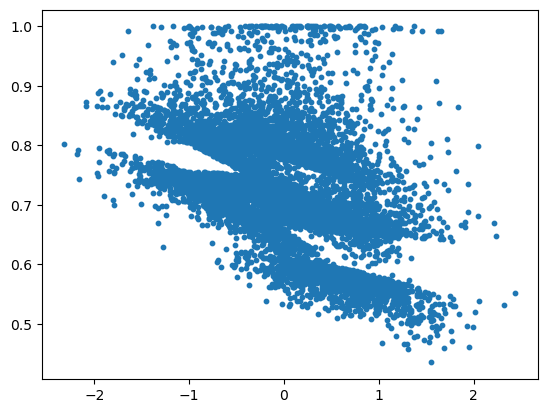

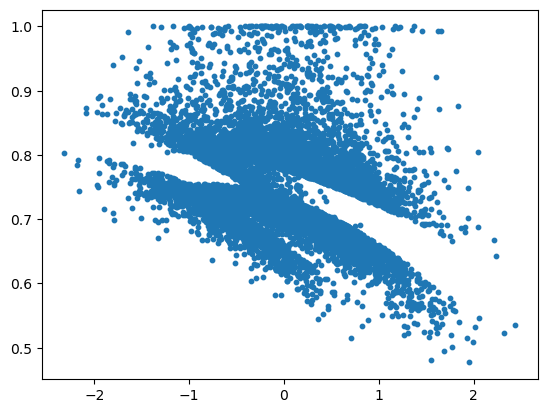

In [2]:
# Generating observatioanl data with configs
seed = 0
N = int(dgp_config['N']/2)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Z,X,Y = DGP(policy = policy,**dgp_config)
Z1,X1,Y1 = Z[:N], X[:N],Y[:N]
Z2,X2,Y2 = Z[N:], X[N:],Y[N:]
plt.scatter(Z @ dgp_config['projection_coeffs'],torch.sigmoid(Y), s = 10);
plt.show()

# Generating interventional data with configs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Zint,Xint,Yint = DGP(policy = new_policy,**dgp_config)
Zint1,Xint1,Yint1 = Zint[:N], Xint[:N],Yint[:N]
Zint2,Xint2,Yint2 = Zint[N:], Xint[N:],Yint[N:]
plt.scatter(Zint @ dgp_config['projection_coeffs'],torch.sigmoid(Yint), s = 10);

# Random dataset shuffle
id = torch.randperm(Z.size(0))
Ztr,Xtr,Ytr = Z[id],X[id],Y[id]

In [3]:
# Model construction
input_dim = dgp_config['D']
factory = FlowFactory(input_dim+1, model_config)
models, hyper_args = factory.build_models()
print(f"Constructed {len(models)} candidate models.")

Constructed 3 candidate models.


In [4]:
# Loss construction
loss= FlowLoss()

In [5]:
# 1. Best overall model (choose one candidate based on average CV loss, then retrain on full training set)
final_model_overall, val_loss_overall = validate(
    models, 
    loss, 
    Xtr, Ytr,
    loss_val=loss,
    method="fixed",
    train_val_split=0.8,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=True
)
print(f"Best overall model validation loss: {val_loss_overall:.4f}")

Epoch 1/100, Training Loss: 1.6475
Epoch 2/100, Training Loss: 1.3618
Epoch 3/100, Training Loss: 1.1488
Epoch 4/100, Training Loss: 1.1126
Epoch 5/100, Training Loss: 0.8890
Epoch 6/100, Training Loss: 0.6678
Epoch 7/100, Training Loss: 0.7285
Epoch 8/100, Training Loss: 0.5600
Epoch 9/100, Training Loss: 0.6560
Epoch 10/100, Training Loss: 0.6035
Epoch 11/100, Training Loss: 0.5783
Epoch 12/100, Training Loss: 0.5021
Epoch 13/100, Training Loss: 0.4374
Epoch 14/100, Training Loss: 0.6318
Epoch 15/100, Training Loss: 0.4815
Epoch 16/100, Training Loss: 0.3670
Epoch 17/100, Training Loss: 0.5090
Epoch 18/100, Training Loss: 0.5535
Epoch 19/100, Training Loss: 0.5649
Epoch 20/100, Training Loss: 0.4441
Epoch 21/100, Training Loss: 0.4331
Epoch 22/100, Training Loss: 0.4681
Epoch 23/100, Training Loss: 0.3256
Epoch 24/100, Training Loss: 0.2949
Epoch 25/100, Training Loss: 0.3004
Epoch 26/100, Training Loss: 0.4119
Epoch 27/100, Training Loss: 0.4238
Epoch 28/100, Training Loss: 0.3988
E

In [6]:
# 2. Best model per fold (select one candidate per fold without retraining)
final_models_per_fold, val_loss_per_fold = validate(
    models, 
    loss, 
    Xtr, Ytr,
    loss_val=loss,
    method="CV",
    train_val_split=0.5,
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="per fold",
    retrain=False
)
print(f"Best per-fold model validation losses: {val_loss_per_fold}")

Epoch 1/100, Training Loss: 1.7455
Epoch 2/100, Training Loss: 1.3893
Epoch 3/100, Training Loss: 1.2998
Epoch 4/100, Training Loss: 4.6721
Epoch 5/100, Training Loss: 1.3254
Epoch 6/100, Training Loss: 4.4560
Epoch 7/100, Training Loss: 2.8258
Epoch 8/100, Training Loss: 2.7092
Epoch 9/100, Training Loss: 0.9623
Epoch 10/100, Training Loss: 2.5570
Epoch 11/100, Training Loss: 0.9727
Epoch 12/100, Training Loss: 0.8629
Epoch 13/100, Training Loss: 0.9037
Epoch 14/100, Training Loss: 2.4900
Epoch 15/100, Training Loss: 0.6839
Epoch 16/100, Training Loss: 5.6418
Epoch 17/100, Training Loss: 0.7091
Epoch 18/100, Training Loss: 0.6615
Epoch 19/100, Training Loss: 0.7192
Epoch 20/100, Training Loss: 0.6991
Epoch 21/100, Training Loss: 0.6316
Epoch 22/100, Training Loss: 0.6341
Epoch 23/100, Training Loss: 2.3102
Epoch 24/100, Training Loss: 0.5576
Epoch 25/100, Training Loss: 2.2656
Epoch 26/100, Training Loss: 2.2249
Epoch 27/100, Training Loss: 3.8362
Epoch 28/100, Training Loss: 0.5172
E

In [7]:
# Predicting counterfactuals+differences
for f in final_models_per_fold:
    f.transformer.logdet = False
final_model_overall.transformer.logdet = False
    
# Predicting counterfactuals+differences
def feature(y):
    return torch.log(1+torch.exp(-y))

#def feature(y):
#    return y
Yint1pred = final_models_per_fold[1].cocycle(Xint1,X1,Y1).detach()
Yint2pred = final_models_per_fold[0].cocycle(Xint2,X2,Y2).detach()
Yintpred_split = torch.concatenate((Yint1pred,Yint2pred))
Yintpred = final_model_overall.cocycle(Xint,X,Y).detach()

counterfactual_diffs = feature(Yint[X[:,0]==2])-feature(Y[X[:,0]==2])
counterfactual_diffpreds = feature(Yintpred[X[:,0]==2])-feature(Y[X[:,0]==2])
counterfactual_diffpreds_split = feature(Yintpred_split[X[:,0]==2])-feature(Y[X[:,0]==2])

In [8]:
((counterfactual_diffs - counterfactual_diffpreds_split).abs()**2).mean()**0.5,((counterfactual_diffs - counterfactual_diffpreds).abs()**2).mean()**0.5

(tensor(0.0575), tensor(0.0327))

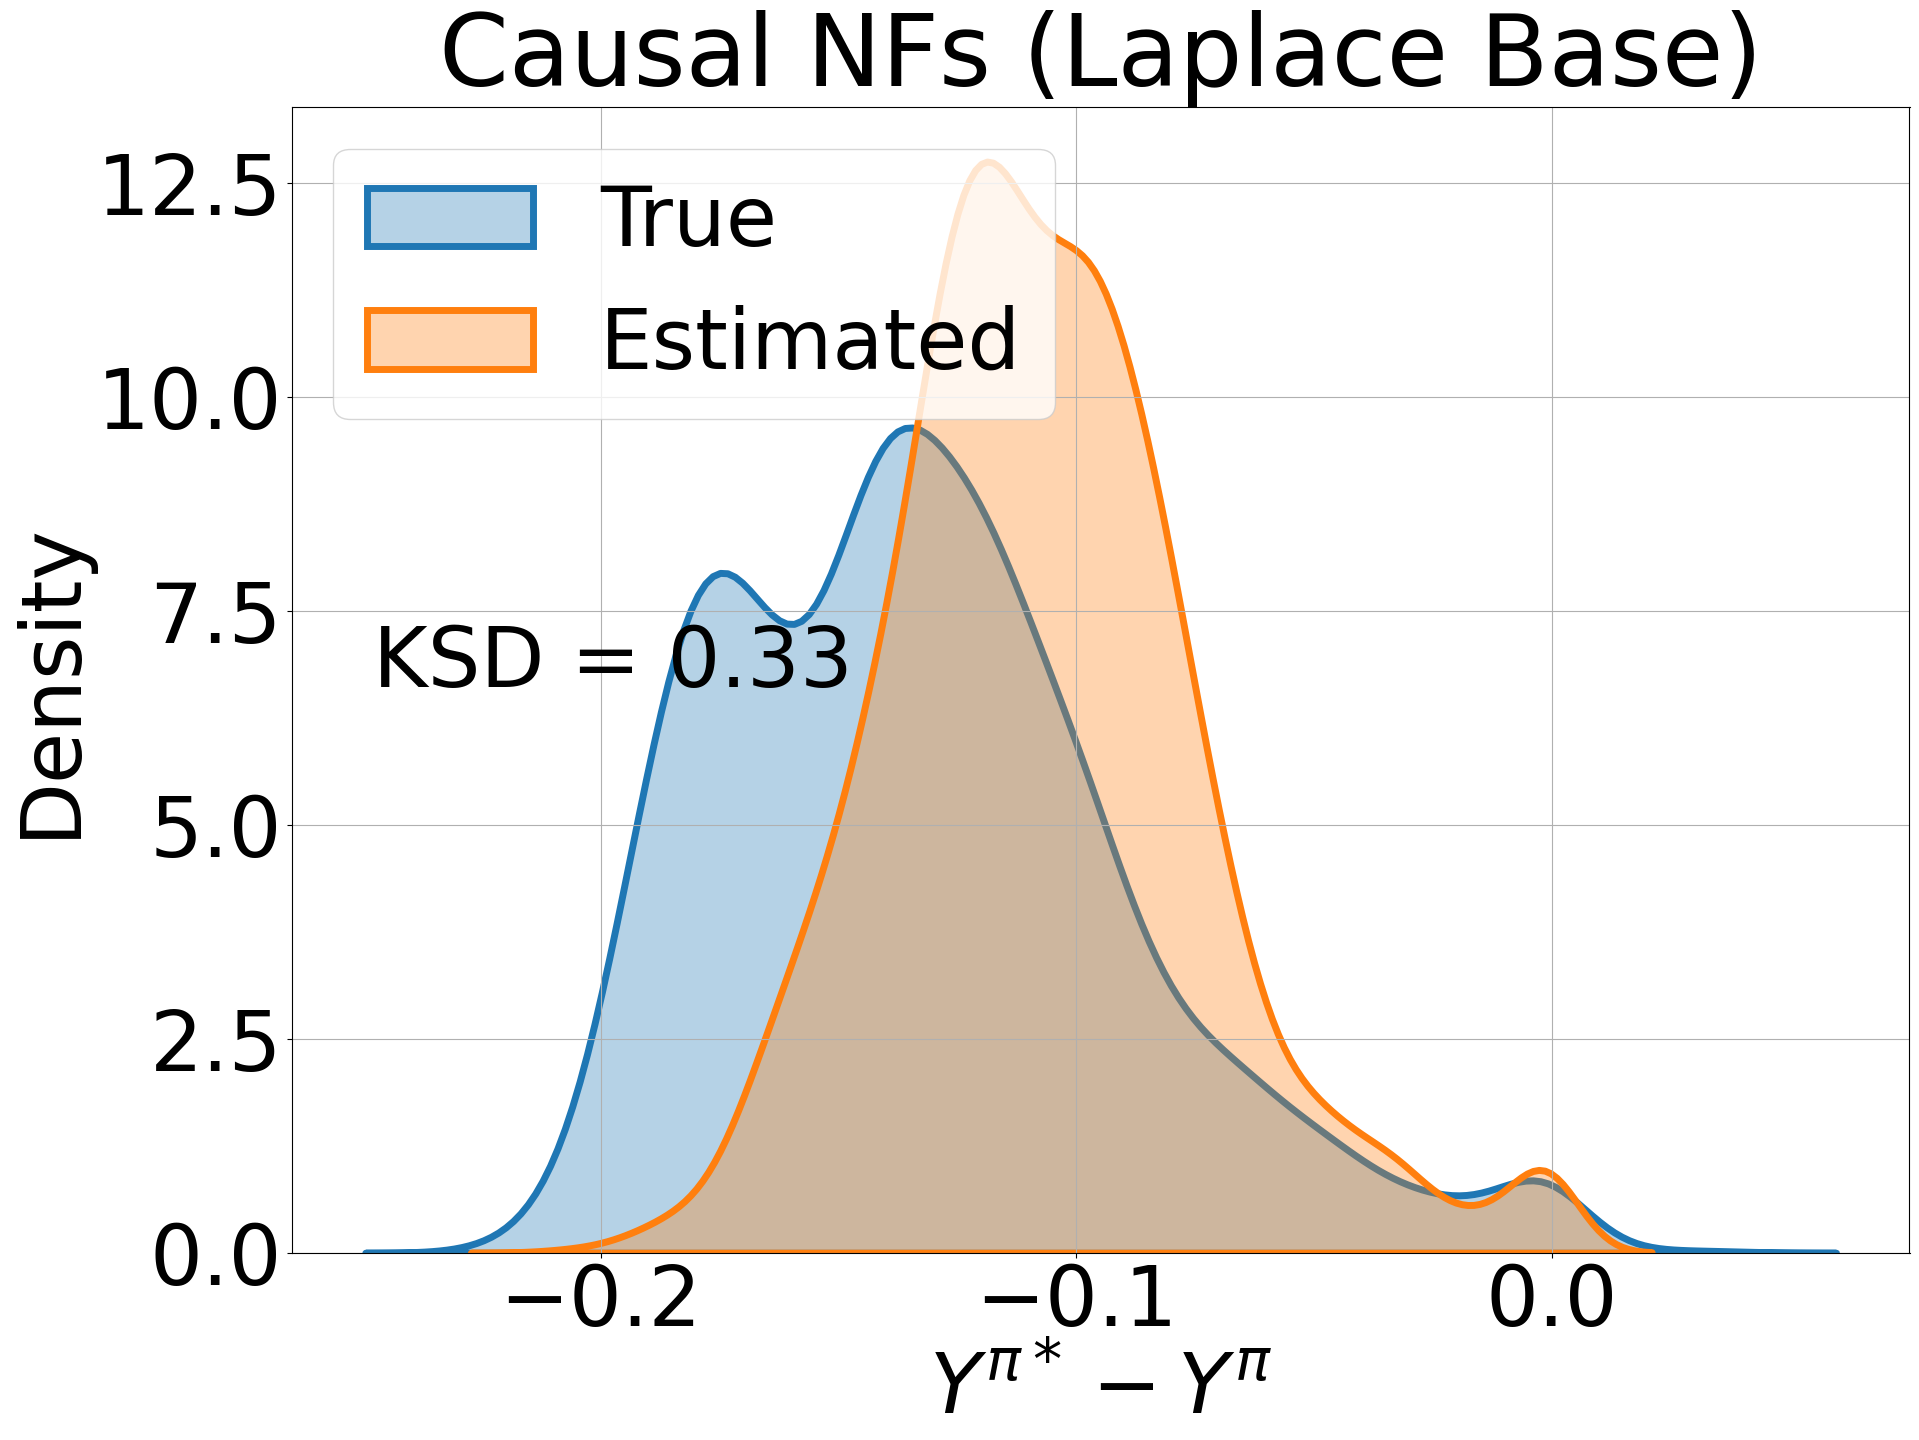

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Update matplotlib rcParams for higher font size and resolution
mpl.rcParams.update({
    'font.size': 60,         # Increase font size (default is usually 10)
    'figure.figsize': (20,16),  # Figure size remains the same as before
    'figure.dpi': 100        # Higher DPI for better fidelity
})

# Compute the KSD values
KSD = kolmogorov_distance(counterfactual_diffs, counterfactual_diffpreds)

# Plug-in based estimator
fig, ax = plt.subplots()
sns.kdeplot(counterfactual_diffs[:, 0], alpha=0.33, fill=True, ax=ax, label="True", lw = 5)
sns.kdeplot(counterfactual_diffpreds[:, 0], alpha=0.33, fill=True, ax=ax, label="Estimated", lw = 5)
ax.set_title("Causal NFs (Laplace Base)")
plt.xlabel(r"$Y^{\pi*} - Y^\pi$")
ax.legend(loc = "upper left")
# Add KSD label for the plug-in estimator
ax.text(0.05, 0.55, f"KSD = {KSD:.2f}", transform=ax.transAxes, verticalalignment='top')
plt.grid(True)
plt.tight_layout()
fig.savefig("SCM_BD_counterfactual_dist_pi_Lap", bbox_inches = "tight")
plt.show()

In [10]:
# Constructing KSD
KSD = kolmogorov_distance(counterfactual_diffs,counterfactual_diffpreds)
KSDsplit = kolmogorov_distance(counterfactual_diffs,counterfactual_diffpreds_split)
print(KSD)
print(KSDsplit)

0.3310917721518988
0.4560917721518988
